<a href="https://colab.research.google.com/github/owensengoku/colabs/blob/main/Capstone_QnABot_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Added a Chatbot GUI to Chat with Your PDF Documents using LLMs (go/yantk-capstone)
---

**Streamlit Chat + LangChain 🦜️🔗  + Vertex AI PaLM API + Matching Engine + Universal Sentence Encoder Multilingual**

---

| | |
|----------|-------------|
| Inspired by   | Rajesh Thallam (rthallam@) |
| Author(s)   | Kin (yantk@) |
| Last updated | 6/6/2023 |

<br/>

| Release Notes||
|----------|-------------|
| Date   | Description |
| 6/14/2023 | Initial version |

---



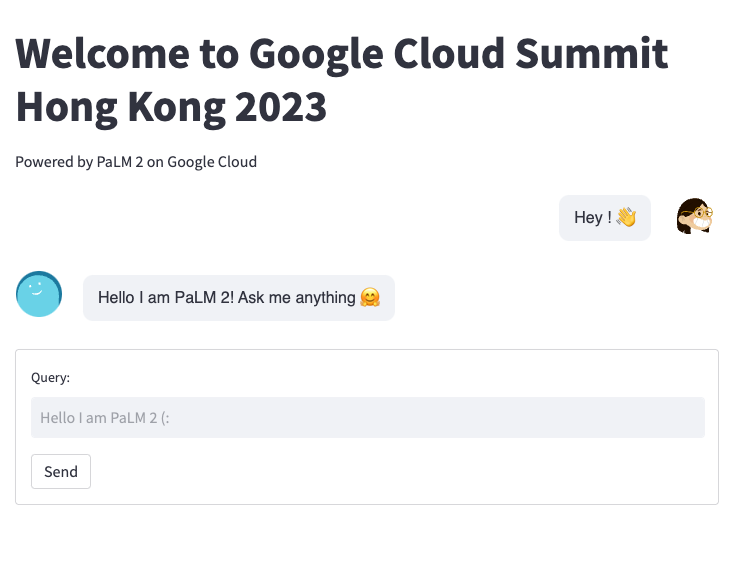

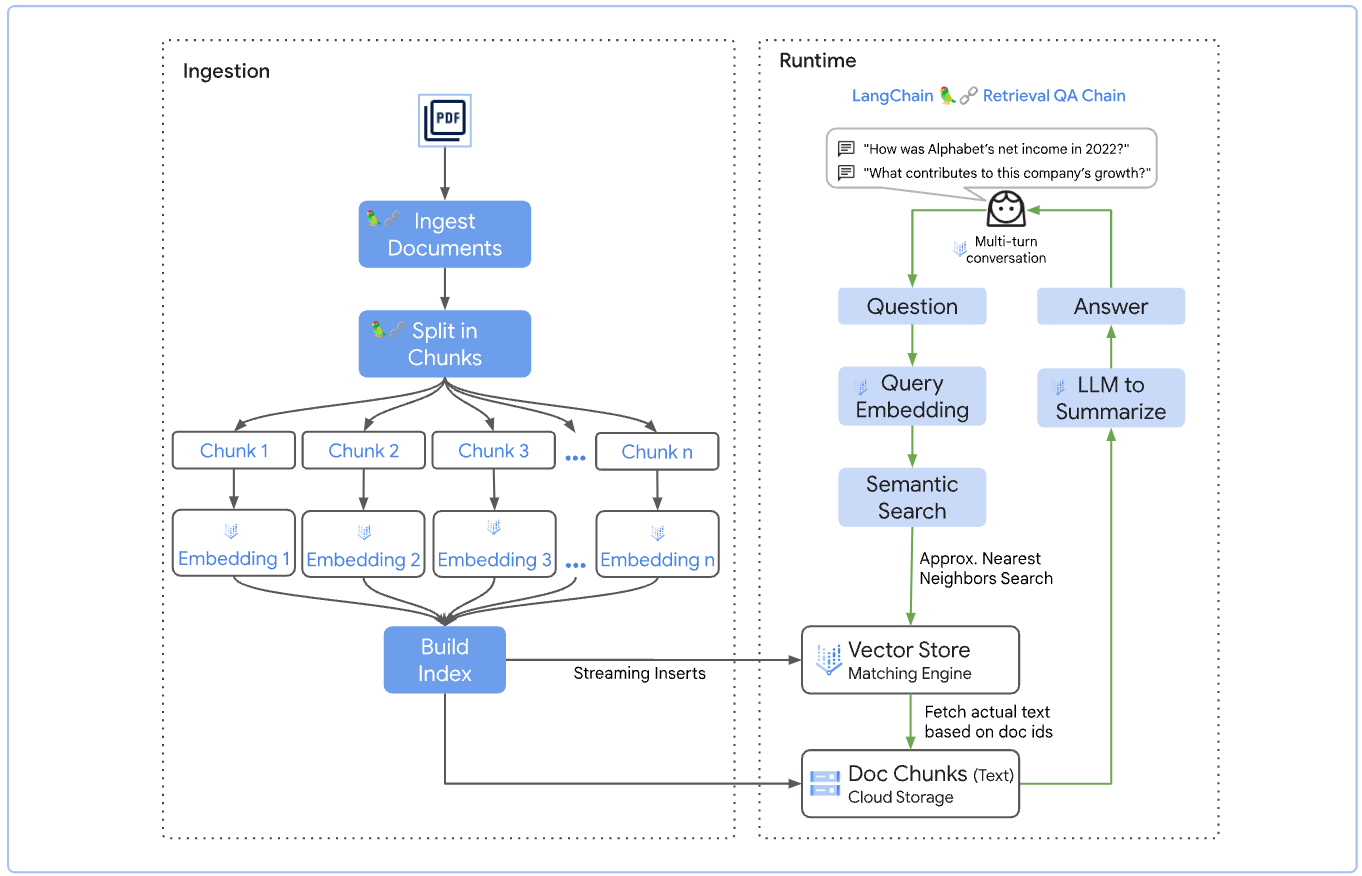

**Inspired by [go/colab-langchain-vertex-genai-me](https://colab.sandbox.google.com/drive/1iXByjtazn-DsIqNpOTRyLfALRu7hOSrQ)**

**This notebook will change the embedding model for multilingual purpose and add a frontend Chatbot UI for event demo purposes**

#### **Install required packages and initialize GCP environment**

In [ ]:
%%capture
!pip install langchain
!pip install google-cloud-aiplatform
!pip install tensorflow_hub tensorflow_text
!pip install shapely
!pip install protobuf
!pip install pypdf
!pip install transformers
!pip install streamlit streamlit_chat
!npm install localtunnel

In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
import numpy as np
from google.cloud import aiplatform
from langchain.llms import VertexAI
from langchain import PromptTemplate, LLMChain
from langchain.vectorstores import MatchingEngine
import vertexai

PROJECT_ID = "michigan-351201"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
STAGING_GCS_BUCKET = "gs://cloud-ai-platform-aed60047-28bc-4337-aa0c-0225591a422e/langchain" # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location=REGION)

#### **Remember to restart the Colab runtime**

#### **Test if LangChain can call PaLM API for Text in Vertex AI**

In [ ]:
%%time
llm = VertexAI(model_name="text-bison", temperature=0.2, max_output_tokens=1024)
sentence = "Parse this address in JSON   - Level 25, Tower 2, Times Square, 1 Matheson St, Causeway Bay" # @param {type:"string"}
print(sentence)
print(llm(sentence))

NameError: ignored

#### **Matching Engine Wrapper**

In [ ]:
# @title Utility functions to create Index and deploy the index to an Endpoint
from datetime import datetime
import time
import logging

from google.cloud import aiplatform_v1 as aipv1
from google.protobuf import struct_pb2

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger()

class MatchingEngineUtils:
    def __init__(self,
                 project_id: str,
                 region: str,
                 index_name: str):
        self.project_id = project_id
        self.region = region
        self.index_name = index_name
        self.index_endpoint_name = f"{self.index_name}-endpoint"
        self.PARENT = f"projects/{self.project_id}/locations/{self.region}"

        ENDPOINT = f"{self.region}-aiplatform.googleapis.com"
        # set index client
        self.index_client = aipv1.IndexServiceClient(
            client_options=dict(api_endpoint=ENDPOINT)
        )
        # set index endpoint client
        self.index_endpoint_client = aipv1.IndexEndpointServiceClient(
            client_options=dict(api_endpoint=ENDPOINT)
        )

    def get_index(self):
        # Check if index exists
        request = aipv1.ListIndexesRequest(parent=self.PARENT)
        page_result = self.index_client.list_indexes(request=request)
        indexes = [response.name for response in page_result
                   if response.display_name == self.index_name]

        if len(indexes) == 0:
            return None
        else:
            index_id = indexes[0]
            request = aipv1.GetIndexRequest(name=index_id)
            index = self.index_client.get_index(request=request)
            return index

    def get_index_endpoint(self):
        # Check if index endpoint exists
        request = aipv1.ListIndexEndpointsRequest(parent=self.PARENT)
        page_result = self.index_endpoint_client.list_index_endpoints(request=request)
        index_endpoints = [response.name for response in page_result
                           if response.display_name == self.index_endpoint_name]

        if len(index_endpoints) == 0:
            return None
        else:
            index_endpoint_id = index_endpoints[0]
            request = aipv1.GetIndexEndpointRequest(name=index_endpoint_id)
            index_endpoint = self.index_endpoint_client.get_index_endpoint(request=request)
            return index_endpoint

    def create_index(self,
                     embedding_gcs_uri: str,
                     dimensions: int
                     ):
        # Get index
        index = self.get_index()
        # Create index if does not exists
        if index:
            logger.info(f"Index {self.index_name} already exists with id {index.name}")
        else:
            logger.info(f"Index {self.index_name} does not exists. Creating index ...")

            treeAhConfig = struct_pb2.Struct(
                fields={
                    "leafNodeEmbeddingCount": struct_pb2.Value(number_value=500),
                    "leafNodesToSearchPercent": struct_pb2.Value(number_value=7),
                }
            )
            algorithmConfig = struct_pb2.Struct(
                fields={"treeAhConfig": struct_pb2.Value(struct_value=treeAhConfig)}
            )
            config = struct_pb2.Struct(
                fields={
                    "dimensions": struct_pb2.Value(number_value=dimensions),
                    "approximateNeighborsCount": struct_pb2.Value(number_value=150),
                    "distanceMeasureType": struct_pb2.Value(string_value="DOT_PRODUCT_DISTANCE"),
                    "algorithmConfig": struct_pb2.Value(struct_value=algorithmConfig),
                    "shardSize": struct_pb2.Value(string_value="SHARD_SIZE_SMALL"),
                }
            )
            metadata = struct_pb2.Struct(
                fields={
                    "config": struct_pb2.Value(struct_value=config),
                    "contentsDeltaUri": struct_pb2.Value(string_value=embedding_gcs_uri),
                }
            )

            index_request = {
                "display_name": self.index_name,
                "description": "Index for LangChain demo",
                "metadata": struct_pb2.Value(struct_value=metadata),
                "index_update_method": aipv1.Index.IndexUpdateMethod.STREAM_UPDATE,
            }

            r = self.index_client.create_index(parent=self.PARENT,
                                               index=index_request)

            # Poll the operation until it's done successfullly.
            logging.info("Poll the operation to create index ...")
            while True:
                if r.done():
                    break
                time.sleep(60)
                print('.', end='')

            index = r.result()
            logger.info(f"Index {self.index_name} created with resource name as {index.name}")

        return index

    def deploy_index(self,
                     machine_type: str = "e2-standard-2",
                     min_replica_count: int = 2,
                     max_replica_count: int = 10,
                     network: str = None):
        try:
            # Get index if exists
            index = self.get_index()
            if not index:
                raise Exception(f"Index {self.index_name} does not exists. Please create index before deploying.")

            # Get index endpoint if exists
            index_endpoint = self.get_index_endpoint()
            # Create Index Endpoint if does not exists
            if index_endpoint:
                logger.info(f"Index endpoint {self.index_endpoint_name} already exists with resource " +
                            f"name as {index_endpoint.name} and endpoint domain name as " +
                            f"{index_endpoint.public_endpoint_domain_name}")
            else:
                logger.info(f"Index endpoint {self.index_endpoint_name} does not exists. Creating index endpoint...")
                index_endpoint_request = {"display_name": self.index_endpoint_name}

                if network:
                    index_endpoint_request["network"] = network
                else:
                    index_endpoint_request["public_endpoint_enabled"] = True

                r = self.index_endpoint_client.create_index_endpoint(
                    parent=self.PARENT,
                    index_endpoint=index_endpoint_request)

                logger.info("Poll the operation to create index endpoint ...")
                while True:
                    if r.done():
                        break
                    time.sleep(60)
                    print('.', end='')

                index_endpoint = r.result()
                logger.info(f"Index endpoint {self.index_endpoint_name} created with resource " +
                            f"name as {index_endpoint.name} and endpoint domain name as " +
                            f"{index_endpoint.public_endpoint_domain_name}")
        except Exception as e:
            logger.error(f"Failed to create index endpoint {self.index_endpoint_name}")
            raise e

        # Deploy Index to endpoint
        try:
            # Check if index is already deployed to the endpoint
            for d_index in index_endpoint.deployed_indexes:
                if d_index.index == index.name:
                    logger.info(f"Skipping deploying Index. Index {self.index_name}" +
                                f"already deployed with id {index.name} to the index endpoint {self.index_endpoint_name}")
                    return index_endpoint

            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            deployed_index_id = f"{self.index_name.replace('-', '_')}_{timestamp}"
            deploy_index = {
                "id": deployed_index_id,
                "display_name": deployed_index_id,
                "index": index.name,
                "dedicated_resources": {
                    "machine_spec": {
                        "machine_type": machine_type,
                        },
                    "min_replica_count": min_replica_count,
                    "max_replica_count": max_replica_count
                    }
            }
            logger.info(f"Deploying index with request = {deploy_index}")
            r = self.index_endpoint_client.deploy_index(
                index_endpoint=index_endpoint.name,
                deployed_index=deploy_index
            )

            # Poll the operation until it's done successfullly.
            logger.info("Poll the operation to deploy index ...")
            while True:
                if r.done():
                    break
                time.sleep(60)
                print('.', end='')

            logger.info(f"Deployed index {self.index_name} to endpoint {self.index_endpoint_name}")

        except Exception as e:
            logger.error(f"Failed to deploy index {self.index_name} to the index endpoint {self.index_endpoint_name}")
            raise e

        return index_endpoint

    def get_index_and_endpoint(self):
        # Get index id if exists
        index = self.get_index()
        index_id = index.name if index else ''

        # Get index endpoint id if exists
        index_endpoint = self.get_index_endpoint()
        index_endpoint_id = index_endpoint.name if index_endpoint else ''

        return index_id, index_endpoint_id

    def delete_index(self):
        # Check if index exists
        index = self.get_index()

        # create index if does not exists
        if index:
            # Delete index
            index_id = index.name
            logger.info(f"Deleting Index {self.index_name} with id {index_id}")
            self.index_client.delete_index(name=index_id)
        else:
            raise Exception("Index {index_name} does not exists.")

    def delete_index_endpoint(self):
        # Check if index endpoint exists
        index_endpoint = self.get_index_endpoint()

        # Create Index Endpoint if does not exists
        if index_endpoint:
            logger.info(f"Index endpoint {self.index_endpoint_name}  exists with resource " +
                        f"name as {index_endpoint.name} and endpoint domain name as " +
                        f"{index_endpoint.public_endpoint_domain_name}")

            index_endpoint_id = index_endpoint.name
            index_endpoint = self.index_endpoint_client.get_index_endpoint(name=index_endpoint_id)
            # Undeploy existing indexes
            for d_index in index_endpoint.deployed_indexes:
                logger.info(f"Undeploying index with id {d_index.id} from Index endpoint {self.index_endpoint_name}")
                request = aipv1.UndeployIndexRequest(
                    index_endpoint=index_endpoint_id,
                    deployed_index_id=d_index.id)
                r = self.index_endpoint_client.undeploy_index(request=request)
                response = r.result()
                logger.info(response)

            # Delete index endpoint
            logger.info(f"Deleting Index endpoint {self.index_endpoint_name} with id {index_endpoint_id}")
            self.index_endpoint_client.delete_index_endpoint(name=index_endpoint_id)
        else:
            raise Exception(f"Index endpoint {self.index_endpoint_name} does not exists.")

In [ ]:
# @title Vertex Matching Engine implementation of the vector store in LangChain
# Ref: https://github.com/hwchase17/langchain/pull/3350
# 04/27/2023: Replace with langchain apis after the PR is merged

"""Vertex Matching Engine implementation of the vector store."""
from __future__ import annotations

import json
import logging
import time
import uuid
from typing import TYPE_CHECKING, Any, Iterable, List, Optional, Type

from langchain.docstore.document import Document
from langchain.embeddings import TensorflowHubEmbeddings
from langchain.embeddings.base import Embeddings
from langchain.vectorstores.base import VectorStore

from google.cloud import storage
from google.cloud.aiplatform import MatchingEngineIndex, MatchingEngineIndexEndpoint
from google.cloud import aiplatform_v1
from google.oauth2.service_account import Credentials
import google.auth
import google.auth.transport.requests

logger = logging.getLogger()


class MatchingEngine(VectorStore):
    """Vertex Matching Engine implementation of the vector store.

    While the embeddings are stored in the Matching Engine, the embedded
    documents will be stored in GCS.

    An existing Index and corresponding Endpoint are preconditions for
    using this module.

    See usage in docs/modules/indexes/vectorstores/examples/matchingengine.ipynb

    Note that this implementation is mostly meant for reading if you are
    planning to do a real time implementation. While reading is a real time
    operation, updating the index takes close to one hour."""

    def __init__(
        self,
        project_id: str,
        region: str,
        index: MatchingEngineIndex,
        endpoint: MatchingEngineIndexEndpoint,
        embedding: Embeddings,
        gcs_client: storage.Client,
        index_client: aiplatform_v1.IndexServiceClient,
        index_endpoint_client: aiplatform_v1.IndexEndpointServiceClient,
        gcs_bucket_name: str,
        credentials: Credentials = None,
    ):
        """Vertex Matching Engine implementation of the vector store.

        While the embeddings are stored in the Matching Engine, the embedded
        documents will be stored in GCS.

        An existing Index and corresponding Endpoint are preconditions for
        using this module.

        See usage in
        docs/modules/indexes/vectorstores/examples/matchingengine.ipynb.

        Note that this implementation is mostly meant for reading if you are
        planning to do a real time implementation. While reading is a real time
        operation, updating the index takes close to one hour.

        Attributes:
            project_id: The GCS project id.
            index: The created index class. See
            ~:func:`MatchingEngine.from_components`.
            endpoint: The created endpoint class. See
            ~:func:`MatchingEngine.from_components`.
            embedding: A :class:`Embeddings` that will be used for
            embedding the text sent. If none is sent, then the
            multilingual Tensorflow Universal Sentence Encoder will be used.
            gcs_client: The Google Cloud Storage client.
            credentials (Optional): Created GCP credentials.
        """
        super().__init__()
        self._validate_google_libraries_installation()

        self.project_id = project_id
        self.region = region
        self.index = index
        self.endpoint = endpoint
        self.embedding = embedding
        self.gcs_client = gcs_client
        self.index_client = index_client
        self.index_endpoint_client = index_endpoint_client
        self.gcs_client = gcs_client
        self.credentials = credentials
        self.gcs_bucket_name = gcs_bucket_name

    def _validate_google_libraries_installation(self) -> None:
        """Validates that Google libraries that are needed are installed."""
        try:
            from google.cloud import aiplatform, storage  # noqa: F401
            from google.oauth2 import service_account  # noqa: F401
        except ImportError:
            raise ImportError(
                "You must run `pip install --upgrade "
                "google-cloud-aiplatform google-cloud-storage`"
                "to use the MatchingEngine Vectorstore."
            )

    def add_texts(
        self,
        texts: Iterable[str],
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> List[str]:
        """Run more texts through the embeddings and add to the vectorstore.

        Args:
            texts: Iterable of strings to add to the vectorstore.
            metadatas: Optional list of metadatas associated with the texts.
            kwargs: vectorstore specific parameters.

        Returns:
            List of ids from adding the texts into the vectorstore.
        """
        logger.debug("Embedding documents.")
        embeddings = self.embedding.embed_documents(list(texts))
        insert_datapoints_payload = []
        ids = []

        # Streaming index update
        for idx, (embedding, text) in enumerate(zip(embeddings, texts)):
            id = uuid.uuid4()
            self._upload_to_gcs(text, f"documents/{id}")
            insert_datapoints_payload.append(aiplatform_v1.IndexDatapoint(
                datapoint_id=str(id),
                feature_vector=embedding))
            if idx %100 == 0:
                upsert_request = aiplatform_v1.UpsertDatapointsRequest(
                    index=self.index.name,
                    datapoints=insert_datapoints_payload
                )
                response = self.index_client.upsert_datapoints(request=upsert_request)
                insert_datapoints_payload = []

        upsert_request = aiplatform_v1.UpsertDatapointsRequest(
            index=self.index.name,
            datapoints=insert_datapoints_payload
        )
        response = self.index_client.upsert_datapoints(request=upsert_request)

        logger.debug("Updated index with new configuration.")

        return ids

    def _upload_to_gcs(self, data: str, gcs_location: str) -> None:
        """Uploads data to gcs_location.

        Args:
            data: The data that will be stored.
            gcs_location: The location where the data will be stored.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        blob = bucket.blob(gcs_location)
        blob.upload_from_string(data)


    def get_matches(
            self,
            embeddings: List[str],
            n_matches: int,
            index_endpoint: MatchingEngineIndexEndpoint) -> str:
        '''
        get matches from matching engine given a vector query
        Uses public endpoint

        '''
        import requests
        import json
        from typing import List

        request_data = {"deployed_index_id": index_endpoint.deployed_indexes[0].id,
                        "queries": [
                            {
                                "datapoint": {
                                    "datapoint_id": f"{i}",
                                    "feature_vector": emb
                                },
                                "neighbor_count": n_matches
                            }
                            for i, emb in enumerate(embeddings)]
                        }

        endpoint_address = self.endpoint.public_endpoint_domain_name
        rpc_address = f'https://{endpoint_address}/v1beta1/{index_endpoint.resource_name}:findNeighbors'
        endpoint_json_data = json.dumps(request_data)

        logger.debug(f"Querying Matching Engine Index Endpoint {rpc_address}")

        header = {'Authorization': 'Bearer ' + self.credentials.token}

        return requests.post(rpc_address, data=endpoint_json_data, headers=header)

    def similarity_search(
        self, query: str, k: int = 4, **kwargs: Any
    ) -> List[Document]:
        """Return docs most similar to query.

        Args:
            query: The string that will be used to search for similar documents.
            k: The amount of neighbors that will be retrieved.

        Returns:
            A list of k matching documents.
        """

        logger.debug(f"Embedding query {query}.")
        embedding_query = self.embedding.embed_documents([query])
        deployed_index_id = self._get_index_id()
        logger.debug(f"Deployed Index ID = {deployed_index_id}")

        # TO-DO: Pending query sdk integration
        # response = self.endpoint.match(
        #     deployed_index_id=self._get_index_id(),
        #     queries=embedding_query,
        #     num_neighbors=k,
        # )

        response = self.get_matches(embedding_query,
                                    k,
                                    self.endpoint)

        if response.status_code == 200:
            response = response.json()["nearestNeighbors"]
        else:
            raise Exception(f"Failed to query index {str(response)}")

        if len(response) == 0:
            return []

        logger.debug(f"Found {len(response)} matches for the query {query}.")

        results = []

        # I'm only getting the first one because queries receives an array
        # and the similarity_search method only recevies one query. This
        # means that the match method will always return an array with only
        # one element.
        for doc in response[0]["neighbors"]:
            page_content = self._download_from_gcs(f"documents/{doc['datapoint']['datapointId']}")
            results.append(Document(page_content=page_content))

        logger.debug("Downloaded documents for query.")

        return results

    def _get_index_id(self) -> str:
        """Gets the correct index id for the endpoint.

        Returns:
            The index id if found (which should be found) or throws
            ValueError otherwise.
        """
        for index in self.endpoint.deployed_indexes:
            if index.index == self.index.name:
                return index.id

        raise ValueError(
            f"No index with id {self.index.name} "
            f"deployed on enpoint "
            f"{self.endpoint.display_name}."
        )

    def _download_from_gcs(self, gcs_location: str) -> str:
        """Downloads from GCS in text format.

        Args:
            gcs_location: The location where the file is located.

        Returns:
            The string contents of the file.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        try:
            blob = bucket.blob(gcs_location)
            return blob.download_as_string()
        except Exception as e:
            return ''

    @classmethod
    def from_texts(
        cls: Type["MatchingEngine"],
        texts: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`from_texts`"
        )

    @classmethod
    def from_documents(
        cls: Type["MatchingEngine"],
        documents: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`from_documents`"
        )

    @classmethod
    def from_components(
        cls: Type["MatchingEngine"],
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        index_id: str,
        endpoint_id: str,
        credentials_path: Optional[str] = None,
        embedding: Optional[Embeddings] = None,
    ) -> "MatchingEngine":
        """Takes the object creation out of the constructor.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: The location where the vectors will be stored in
            order for the index to be created.
            index_id: The id of the created index.
            endpoint_id: The id of the created endpoint.
            credentials_path: (Optional) The path of the Google credentials on
            the local file system.
            embedding: The :class:`Embeddings` that will be used for
            embedding the texts.

        Returns:
            A configured MatchingEngine with the texts added to the index.
        """
        gcs_bucket_name = cls._validate_gcs_bucket(gcs_bucket_name)

        # Set credentials
        if credentials_path:
            credentials = cls._create_credentials_from_file(credentials_path)
        else:
            credentials, _ = google.auth.default()
            request = google.auth.transport.requests.Request()
            credentials.refresh(request)

        index = cls._create_index_by_id(index_id, project_id, region, credentials)
        endpoint = cls._create_endpoint_by_id(
            endpoint_id, project_id, region, credentials
        )

        gcs_client = cls._get_gcs_client(credentials, project_id)
        index_client = cls._get_index_client(project_id, region, credentials)
        index_endpoint_client = cls._get_index_endpoint_client(project_id, region, credentials)
        cls._init_aiplatform(project_id, region, gcs_bucket_name, credentials)

        return cls(
            project_id=project_id,
            region=region,
            index=index,
            endpoint=endpoint,
            embedding=embedding or cls._get_default_embeddings(),
            gcs_client=gcs_client,
            index_client=index_client,
            index_endpoint_client=index_endpoint_client,
            credentials=credentials,
            gcs_bucket_name=gcs_bucket_name,
        )

    @classmethod
    def _validate_gcs_bucket(cls, gcs_bucket_name: str) -> str:
        """Validates the gcs_bucket_name as a bucket name.

        Args:
              gcs_bucket_name: The received bucket uri.

        Returns:
              A valid gcs_bucket_name or throws ValueError if full path is
              provided.
        """
        gcs_bucket_name = gcs_bucket_name.replace("gs://", "")
        if "/" in gcs_bucket_name:
            raise ValueError(
                f"The argument gcs_bucket_name should only be "
                f"the bucket name. Received {gcs_bucket_name}"
            )
        return gcs_bucket_name

    @classmethod
    def _create_credentials_from_file(
        cls, json_credentials_path: Optional[str]
    ) -> Optional[Credentials]:
        """Creates credentials for GCP.

        Args:
             json_credentials_path: The path on the file system where the
             credentials are stored.

         Returns:
             An optional of Credentials or None, in which case the default
             will be used.
        """

        from google.oauth2 import service_account

        credentials = None
        if json_credentials_path is not None:
            credentials = service_account.Credentials.from_service_account_file(
                json_credentials_path
            )

        return credentials

    @classmethod
    def _create_index_by_id(
        cls, index_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndex:
        """Creates a MatchingEngineIndex object by id.

        Args:
            index_id: The created index id.

        Returns:
            A configured MatchingEngineIndex.
        """

        from google.cloud import aiplatform_v1

        logger.debug(f"Creating matching engine index with id {index_id}.")
        index_client = cls._get_index_client(project_id, region, credentials)
        request = aiplatform_v1.GetIndexRequest(name=index_id)
        return index_client.get_index(request=request)


    @classmethod
    def _create_endpoint_by_id(
        cls, endpoint_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndexEndpoint:
        """Creates a MatchingEngineIndexEndpoint object by id.

        Args:
            endpoint_id: The created endpoint id.

        Returns:
            A configured MatchingEngineIndexEndpoint.
            :param project_id:
            :param region:
            :param credentials:
        """

        from google.cloud import aiplatform

        logger.debug(f"Creating endpoint with id {endpoint_id}.")
        return aiplatform.MatchingEngineIndexEndpoint(
            index_endpoint_name=endpoint_id,
            project=project_id,
            location=region,
            credentials=credentials,
        )


    @classmethod
    def _get_gcs_client(
        cls, credentials: "Credentials", project_id: str
    ) -> "storage.Client":
        """Lazily creates a GCS client.

        Returns:
            A configured GCS client.
        """

        from google.cloud import storage

        return storage.Client(credentials=credentials, project=project_id)

    @classmethod
    def _get_index_client(
        cls, project_id: str, region: str, credentials: "Credentials"
    ) -> "storage.Client":
        """Lazily creates a Matching Engine Index client.

        Returns:
            A configured Matching Engine Index client.
        """

        from google.cloud import aiplatform_v1

        PARENT = f"projects/{project_id}/locations/{region}"
        ENDPOINT = f"{region}-aiplatform.googleapis.com"
        return aiplatform_v1.IndexServiceClient(
            client_options=dict(api_endpoint=ENDPOINT),
            credentials=credentials
        )

    @classmethod
    def _get_index_endpoint_client(
        cls, project_id: str, region: str, credentials: "Credentials"
    ) -> "storage.Client":
        """Lazily creates a Matching Engine Index Endpoint client.

        Returns:
            A configured Matching Engine Index Endpoint client.
        """

        from google.cloud import aiplatform_v1

        PARENT = f"projects/{project_id}/locations/{region}"
        ENDPOINT = f"{region}-aiplatform.googleapis.com"
        return aiplatform_v1.IndexEndpointServiceClient(
            client_options=dict(api_endpoint=ENDPOINT),
            credentials=credentials
        )


    @classmethod
    def _init_aiplatform(
        cls,
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        credentials: "Credentials",
    ) -> None:
        """Configures the aiplatform library.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: GCS staging location.
            credentials: The GCS Credentials object.
        """

        from google.cloud import aiplatform

        logger.debug(
            f"Initializing AI Platform for project {project_id} on "
            f"{region} and for {gcs_bucket_name}."
        )
        aiplatform.init(
            project=project_id,
            location=region,
            staging_bucket=gcs_bucket_name,
            credentials=credentials,
        )

    @classmethod
    def _get_default_embeddings(cls) -> TensorflowHubEmbeddings:
        """This function returns the default embedding."""
        return TensorflowHubEmbeddings()

#### **Create Matching Engine if it does not exist**

In [ ]:
# @title Select the Embedding Model you used in go/colab-langchain-vertex-genai-me

Embedding_Model = "Universal Sentence Encoder" #@param ["Vertex AI", "Universal Sentence Encoder"]

if Embedding_Model == "Vertex AI":
  from langchain.embeddings import VertexAIEmbeddings
  embedding = VertexAIEmbeddings()
  ME_DIMENSIONS = 768
if Embedding_Model == "Universal Sentence Encoder" :
  from langchain.embeddings import TensorflowHubEmbeddings
  url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
  embedding = TensorflowHubEmbeddings(model_url=url)
  ME_DIMENSIONS = 512


In [ ]:
ME_REGION          = "us-central1" # @param {type:"string"}
ME_INDEX_NAME      = "langchain-vector-store" # @param {type:"string"}
ME_EMBEDDING_DIR   = "gs://cloud-ai-platform-aed60047-28bc-4337-aa0c-0225591a422e/MEembedding" # @param {type:"string"}

In [ ]:
from google.cloud import storage

# dummy embedding
init_embedding = {"id": str(uuid.uuid4()),
                  "embedding": list(np.zeros(ME_DIMENSIONS))}

# dump embedding to a local file
with open("embeddings_0.json", "w") as f:
    json.dump(init_embedding, f)

# write embedding to Cloud Storage
! gsutil cp embeddings_0.json {ME_EMBEDDING_DIR}/init_index/embeddings_0.json

Copying file://embeddings_0.json [Content-Type=application/json]...
/ [1 files][  2.6 KiB/  2.6 KiB]                                                
Operation completed over 1 objects/2.6 KiB.                                      


In [ ]:
mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)

In [ ]:
index = mengine.create_index(f"{ME_EMBEDDING_DIR}/init_index", ME_DIMENSIONS)
if index:
  print(index.name)

projects/16838415269/locations/us-central1/indexes/3989160126966661120


In [ ]:
index_endpoint = mengine.deploy_index()
if index_endpoint:
  print(f"Index endpoint resource name: {index_endpoint.name}")
  print(f"Index endpoint public domain name: {index_endpoint.public_endpoint_domain_name}")
  print(f"Deployed indexes on the index endpoint:")
  for d in index_endpoint.deployed_indexes:
    print(f"    {d.id}")

Index endpoint resource name: projects/16838415269/locations/us-central1/indexEndpoints/5139266881806401536
Index endpoint public domain name: 1701367856.us-central1-16838415269.vdb.vertexai.goog
Deployed indexes on the index endpoint:
    langchain_vector_store_20230523055920


In [ ]:
# initialize vector store
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f'gs://{ME_EMBEDDING_DIR.split("/")[2]}',
    embedding=embedding,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID
)

#### **Ingest PDF Embedding and Chunks to Matching Engine and GCS**

In [ ]:
urls = []

In [ ]:
# @title Specify PDF file link and run this cell repeatedly if more than 3 pdf needs to be added
pdf1 = "https://www.budget.gov.hk/2023/chi/pdf/Budget23-24_Chi_Leaflet.pdf" # @param {type:"string"}
pdf2 = "https://www.budget.gov.hk/2023/chi/pdf/2023-24_Media_Sheet.pdf" # @param {type:"string"}
pdf3 = "https://www.budget.gov.hk/2023/chi/pdf/chead021.pdf" # @param {type:"string"}
pdfs = [pdf1, pdf2, pdf3,]

for pdf in pdfs:
  if pdf not in urls:
    urls.append(pdf)

In [ ]:
# Ingest PDF files
from langchain.document_loaders import PyPDFLoader

documents = []

for url in urls:
    loader = PyPDFLoader(url)
    documents.extend(loader.load())

print(f"# of pages loaded (pre-chunking) = {len(documents)}")

# split the documents into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents)
print(f"# of documents = {len(doc_splits)}")

# Store docs as embeddings in Matching Engine index
# It may take a while since API is rate limited
texts = [doc.page_content for doc in doc_splits]
me.add_texts(texts=texts)


#### **QnA test**

In [ ]:
# Create chain to answer questions
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

prompt_template = """Use the following pieces of context to answer the question at the end and step by step. If you don't know the answer, just say that '唔好意思，我喺資料庫搵唔到答案。請你去問 Google 啦。', don't try to make up an answer.

{context}

Question: {question}
Answer in Traditional Chinese:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

NUMBER_OF_RESULTS = 10

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={"k":NUMBER_OF_RESULTS})

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
chain_type_kwargs = {"prompt": PROMPT}
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs=chain_type_kwargs)

In [ ]:
def formatter(result):
    #print(f"Query: {result['query']}")
    print(f"Query: {query}")
    print("."*80)
    print(f"Response: {result['result']}")
    if 'source_documents' in result.keys():
      print("."*80)
      print(f"References: {result['source_documents']}")

In [ ]:
%%time
query = "今年消費券有多少錢？"
result = qa({"query": query})
formatter(result)

Query: 今年消費券有多少錢？
................................................................................
Response:  今年會向每名合資格的十八歲或以上永久性居民及新來港人士分期發放總額五千元電子消費券。 

 為盡快發放消費券， 政府會先通過去年計劃的登記資料，在今年四月發放首三千元消費券給合資格人士， 餘額會
與新符合資格人士一起在今年年 中發放。 與去年安排一樣 ，透 過不同入境計劃在港居住及來港升學的合資格人士， 會獲發上述
總額一半 ，即合共二千五百元的消費券。 我們會盡快公布詳情。
................................................................................
References: [Document(page_content='復常下力保全速復蘇  \n \n \n \n9 \n 派發消費券  \n37. 政府於過去兩年推行了兩輪消費券計劃 ，分別向超過\n六百萬名合資格市民發放五千元及一萬元電子消費券。社會\n反  應正面。 \n38. 考慮了當前經濟、社會民生及政府財政狀況後 ，今年\n我會再向每名合資格的十八歲或以上永久性居民及新來港人士分兩期發放總額五千元電子消費券。 \n39. 為盡快發放消費券， 政府會先通過去年計劃的登記\n資\n 料，在今年四月發放首三千元消費券給合資格人士， 餘額會\n與新符合資格人士一起在今年年 中發放。 與去年安排一樣 ，透  過\n不同入境計劃在港居住及來港升學的合資格人士， 會獲發上述\n總額一半 ，即合共二千五百元的消費券。 我們會盡快公布詳情。  \n支援企業  \n40. 在紓緩經營壓力方面， 我建議：  \n（一） 寬減二零二二／二三課稅年度百分之百的利得稅，\n上  限為六千元 ，全港十三萬 四千家企業受惠。有關\n扣  減會在二零二二／二三課稅年度的最終應繳稅款\n反映。政府收入將減少七 億二千萬元； \n（二） 寬減二零二三／二四年度首兩季的非住宅物業差\n 餉，以每戶每季一千元為上限。估計涉及四十三萬\n個非  住  宅物業。政府收入將減少七 億四千萬元 ；及', metadata={}), Document(pa

#### **Write code to Python file**

In [ ]:
# @title Python file
%%writefile Google_PaLM2.py

"""Vertex Matching Engine implementation of the vector store."""
from __future__ import annotations
# @title Utility functions to create Index and deploy the index to an Endpoint
from datetime import datetime
import time
import logging

from google.cloud import aiplatform_v1 as aipv1
from google.protobuf import struct_pb2

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger()

class MatchingEngineUtils:
    def __init__(self,
                 project_id: str,
                 region: str,
                 index_name: str):
        self.project_id = project_id
        self.region = region
        self.index_name = index_name
        self.index_endpoint_name = f"{self.index_name}-endpoint"
        self.PARENT = f"projects/{self.project_id}/locations/{self.region}"

        ENDPOINT = f"{self.region}-aiplatform.googleapis.com"
        # set index client
        self.index_client = aipv1.IndexServiceClient(
            client_options=dict(api_endpoint=ENDPOINT)
        )
        # set index endpoint client
        self.index_endpoint_client = aipv1.IndexEndpointServiceClient(
            client_options=dict(api_endpoint=ENDPOINT)
        )

    def get_index(self):
        # Check if index exists
        request = aipv1.ListIndexesRequest(parent=self.PARENT)
        page_result = self.index_client.list_indexes(request=request)
        indexes = [response.name for response in page_result
                   if response.display_name == self.index_name]

        if len(indexes) == 0:
            return None
        else:
            index_id = indexes[0]
            request = aipv1.GetIndexRequest(name=index_id)
            index = self.index_client.get_index(request=request)
            return index

    def get_index_endpoint(self):
        # Check if index endpoint exists
        request = aipv1.ListIndexEndpointsRequest(parent=self.PARENT)
        page_result = self.index_endpoint_client.list_index_endpoints(request=request)
        index_endpoints = [response.name for response in page_result
                           if response.display_name == self.index_endpoint_name]

        if len(index_endpoints) == 0:
            return None
        else:
            index_endpoint_id = index_endpoints[0]
            request = aipv1.GetIndexEndpointRequest(name=index_endpoint_id)
            index_endpoint = self.index_endpoint_client.get_index_endpoint(request=request)
            return index_endpoint

    def create_index(self,
                     embedding_gcs_uri: str,
                     dimensions: int
                     ):
        # Get index
        index = self.get_index()
        # Create index if does not exists
        if index:
            logger.info(f"Index {self.index_name} already exists with id {index.name}")
        else:
            logger.info(f"Index {self.index_name} does not exists. Creating index ...")

            treeAhConfig = struct_pb2.Struct(
                fields={
                    "leafNodeEmbeddingCount": struct_pb2.Value(number_value=500),
                    "leafNodesToSearchPercent": struct_pb2.Value(number_value=7),
                }
            )
            algorithmConfig = struct_pb2.Struct(
                fields={"treeAhConfig": struct_pb2.Value(struct_value=treeAhConfig)}
            )
            config = struct_pb2.Struct(
                fields={
                    "dimensions": struct_pb2.Value(number_value=dimensions),
                    "approximateNeighborsCount": struct_pb2.Value(number_value=150),
                    "distanceMeasureType": struct_pb2.Value(string_value="DOT_PRODUCT_DISTANCE"),
                    "algorithmConfig": struct_pb2.Value(struct_value=algorithmConfig),
                    "shardSize": struct_pb2.Value(string_value="SHARD_SIZE_SMALL"),
                }
            )
            metadata = struct_pb2.Struct(
                fields={
                    "config": struct_pb2.Value(struct_value=config),
                    "contentsDeltaUri": struct_pb2.Value(string_value=embedding_gcs_uri),
                }
            )

            index_request = {
                "display_name": self.index_name,
                "description": "Index for LangChain demo",
                "metadata": struct_pb2.Value(struct_value=metadata),
                "index_update_method": aipv1.Index.IndexUpdateMethod.STREAM_UPDATE,
            }

            r = self.index_client.create_index(parent=self.PARENT,
                                               index=index_request)

            # Poll the operation until it's done successfullly.
            logging.info("Poll the operation to create index ...")
            while True:
                if r.done():
                    break
                time.sleep(60)
                print('.', end='')

            index = r.result()
            logger.info(f"Index {self.index_name} created with resource name as {index.name}")

        return index

    def deploy_index(self,
                     machine_type: str = "e2-standard-2",
                     min_replica_count: int = 2,
                     max_replica_count: int = 10,
                     network: str = None):
        try:
            # Get index if exists
            index = self.get_index()
            if not index:
                raise Exception(f"Index {self.index_name} does not exists. Please create index before deploying.")

            # Get index endpoint if exists
            index_endpoint = self.get_index_endpoint()
            # Create Index Endpoint if does not exists
            if index_endpoint:
                logger.info(f"Index endpoint {self.index_endpoint_name} already exists with resource " +
                            f"name as {index_endpoint.name} and endpoint domain name as " +
                            f"{index_endpoint.public_endpoint_domain_name}")
            else:
                logger.info(f"Index endpoint {self.index_endpoint_name} does not exists. Creating index endpoint...")
                index_endpoint_request = {"display_name": self.index_endpoint_name}

                if network:
                    index_endpoint_request["network"] = network
                else:
                    index_endpoint_request["public_endpoint_enabled"] = True

                r = self.index_endpoint_client.create_index_endpoint(
                    parent=self.PARENT,
                    index_endpoint=index_endpoint_request)

                logger.info("Poll the operation to create index endpoint ...")
                while True:
                    if r.done():
                        break
                    time.sleep(60)
                    print('.', end='')

                index_endpoint = r.result()
                logger.info(f"Index endpoint {self.index_endpoint_name} created with resource " +
                            f"name as {index_endpoint.name} and endpoint domain name as " +
                            f"{index_endpoint.public_endpoint_domain_name}")
        except Exception as e:
            logger.error(f"Failed to create index endpoint {self.index_endpoint_name}")
            raise e

        # Deploy Index to endpoint
        try:
            # Check if index is already deployed to the endpoint
            for d_index in index_endpoint.deployed_indexes:
                if d_index.index == index.name:
                    logger.info(f"Skipping deploying Index. Index {self.index_name}" +
                                f"already deployed with id {index.name} to the index endpoint {self.index_endpoint_name}")
                    return index_endpoint

            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            deployed_index_id = f"{self.index_name.replace('-', '_')}_{timestamp}"
            deploy_index = {
                "id": deployed_index_id,
                "display_name": deployed_index_id,
                "index": index.name,
                "dedicated_resources": {
                    "machine_spec": {
                        "machine_type": machine_type,
                        },
                    "min_replica_count": min_replica_count,
                    "max_replica_count": max_replica_count
                    }
            }
            logger.info(f"Deploying index with request = {deploy_index}")
            r = self.index_endpoint_client.deploy_index(
                index_endpoint=index_endpoint.name,
                deployed_index=deploy_index
            )

            # Poll the operation until it's done successfullly.
            logger.info("Poll the operation to deploy index ...")
            while True:
                if r.done():
                    break
                time.sleep(60)
                print('.', end='')

            logger.info(f"Deployed index {self.index_name} to endpoint {self.index_endpoint_name}")

        except Exception as e:
            logger.error(f"Failed to deploy index {self.index_name} to the index endpoint {self.index_endpoint_name}")
            raise e

        return index_endpoint

    def get_index_and_endpoint(self):
        # Get index id if exists
        index = self.get_index()
        index_id = index.name if index else ''

        # Get index endpoint id if exists
        index_endpoint = self.get_index_endpoint()
        index_endpoint_id = index_endpoint.name if index_endpoint else ''

        return index_id, index_endpoint_id

    def delete_index(self):
        # Check if index exists
        index = self.get_index()

        # create index if does not exists
        if index:
            # Delete index
            index_id = index.name
            logger.info(f"Deleting Index {self.index_name} with id {index_id}")
            self.index_client.delete_index(name=index_id)
        else:
            raise Exception("Index {index_name} does not exists.")

    def delete_index_endpoint(self):
        # Check if index endpoint exists
        index_endpoint = self.get_index_endpoint()

        # Create Index Endpoint if does not exists
        if index_endpoint:
            logger.info(f"Index endpoint {self.index_endpoint_name}  exists with resource " +
                        f"name as {index_endpoint.name} and endpoint domain name as " +
                        f"{index_endpoint.public_endpoint_domain_name}")

            index_endpoint_id = index_endpoint.name
            index_endpoint = self.index_endpoint_client.get_index_endpoint(name=index_endpoint_id)
            # Undeploy existing indexes
            for d_index in index_endpoint.deployed_indexes:
                logger.info(f"Undeploying index with id {d_index.id} from Index endpoint {self.index_endpoint_name}")
                request = aipv1.UndeployIndexRequest(
                    index_endpoint=index_endpoint_id,
                    deployed_index_id=d_index.id)
                r = self.index_endpoint_client.undeploy_index(request=request)
                response = r.result()
                logger.info(response)

            # Delete index endpoint
            logger.info(f"Deleting Index endpoint {self.index_endpoint_name} with id {index_endpoint_id}")
            self.index_endpoint_client.delete_index_endpoint(name=index_endpoint_id)
        else:
            raise Exception(f"Index endpoint {self.index_endpoint_name} does not exists.")

import json
import logging
import time
import uuid
from typing import TYPE_CHECKING, Any, Iterable, List, Optional, Type

from langchain.docstore.document import Document
from langchain.embeddings import TensorflowHubEmbeddings
from langchain.embeddings.base import Embeddings
from langchain.vectorstores.base import VectorStore

from google.cloud import storage
from google.cloud.aiplatform import MatchingEngineIndex, MatchingEngineIndexEndpoint
from google.cloud import aiplatform_v1
from google.oauth2.service_account import Credentials
import google.auth
import google.auth.transport.requests

logger = logging.getLogger()


class MatchingEngine(VectorStore):
    """Vertex Matching Engine implementation of the vector store.

    While the embeddings are stored in the Matching Engine, the embedded
    documents will be stored in GCS.

    An existing Index and corresponding Endpoint are preconditions for
    using this module.

    See usage in docs/modules/indexes/vectorstores/examples/matchingengine.ipynb

    Note that this implementation is mostly meant for reading if you are
    planning to do a real time implementation. While reading is a real time
    operation, updating the index takes close to one hour."""

    def __init__(
        self,
        project_id: str,
        region: str,
        index: MatchingEngineIndex,
        endpoint: MatchingEngineIndexEndpoint,
        embedding: Embeddings,
        gcs_client: storage.Client,
        index_client: aiplatform_v1.IndexServiceClient,
        index_endpoint_client: aiplatform_v1.IndexEndpointServiceClient,
        gcs_bucket_name: str,
        credentials: Credentials = None,
    ):
        """Vertex Matching Engine implementation of the vector store.

        While the embeddings are stored in the Matching Engine, the embedded
        documents will be stored in GCS.

        An existing Index and corresponding Endpoint are preconditions for
        using this module.

        See usage in
        docs/modules/indexes/vectorstores/examples/matchingengine.ipynb.

        Note that this implementation is mostly meant for reading if you are
        planning to do a real time implementation. While reading is a real time
        operation, updating the index takes close to one hour.

        Attributes:
            project_id: The GCS project id.
            index: The created index class. See
            ~:func:`MatchingEngine.from_components`.
            endpoint: The created endpoint class. See
            ~:func:`MatchingEngine.from_components`.
            embedding: A :class:`Embeddings` that will be used for
            embedding the text sent. If none is sent, then the
            multilingual Tensorflow Universal Sentence Encoder will be used.
            gcs_client: The Google Cloud Storage client.
            credentials (Optional): Created GCP credentials.
        """
        super().__init__()
        self._validate_google_libraries_installation()

        self.project_id = project_id
        self.region = region
        self.index = index
        self.endpoint = endpoint
        self.embedding = embedding
        self.gcs_client = gcs_client
        self.index_client = index_client
        self.index_endpoint_client = index_endpoint_client
        self.gcs_client = gcs_client
        self.credentials = credentials
        self.gcs_bucket_name = gcs_bucket_name

    def _validate_google_libraries_installation(self) -> None:
        """Validates that Google libraries that are needed are installed."""
        try:
            from google.cloud import aiplatform, storage  # noqa: F401
            from google.oauth2 import service_account  # noqa: F401
        except ImportError:
            raise ImportError(
                "You must run `pip install --upgrade "
                "google-cloud-aiplatform google-cloud-storage`"
                "to use the MatchingEngine Vectorstore."
            )

    def add_texts(
        self,
        texts: Iterable[str],
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> List[str]:
        """Run more texts through the embeddings and add to the vectorstore.

        Args:
            texts: Iterable of strings to add to the vectorstore.
            metadatas: Optional list of metadatas associated with the texts.
            kwargs: vectorstore specific parameters.

        Returns:
            List of ids from adding the texts into the vectorstore.
        """
        logger.debug("Embedding documents.")
        embeddings = self.embedding.embed_documents(list(texts))
        insert_datapoints_payload = []
        ids = []

        # Streaming index update
        for idx, (embedding, text) in enumerate(zip(embeddings, texts)):
            id = uuid.uuid4()
            self._upload_to_gcs(text, f"documents/{id}")
            insert_datapoints_payload.append(aiplatform_v1.IndexDatapoint(
                datapoint_id=str(id),
                feature_vector=embedding))
            if idx %100 == 0:
                upsert_request = aiplatform_v1.UpsertDatapointsRequest(
                    index=self.index.name,
                    datapoints=insert_datapoints_payload
                )
                response = self.index_client.upsert_datapoints(request=upsert_request)
                insert_datapoints_payload = []

        upsert_request = aiplatform_v1.UpsertDatapointsRequest(
            index=self.index.name,
            datapoints=insert_datapoints_payload
        )
        response = self.index_client.upsert_datapoints(request=upsert_request)

        logger.debug("Updated index with new configuration.")

        return ids

    def _upload_to_gcs(self, data: str, gcs_location: str) -> None:
        """Uploads data to gcs_location.

        Args:
            data: The data that will be stored.
            gcs_location: The location where the data will be stored.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        blob = bucket.blob(gcs_location)
        blob.upload_from_string(data)


    def get_matches(
            self,
            embeddings: List[str],
            n_matches: int,
            index_endpoint: MatchingEngineIndexEndpoint) -> str:
        '''
        get matches from matching engine given a vector query
        Uses public endpoint

        '''
        import requests
        import json
        from typing import List

        request_data = {"deployed_index_id": index_endpoint.deployed_indexes[0].id,
                        "queries": [
                            {
                                "datapoint": {
                                    "datapoint_id": f"{i}",
                                    "feature_vector": emb
                                },
                                "neighbor_count": n_matches
                            }
                            for i, emb in enumerate(embeddings)]
                        }

        endpoint_address = self.endpoint.public_endpoint_domain_name
        rpc_address = f'https://{endpoint_address}/v1beta1/{index_endpoint.resource_name}:findNeighbors'
        endpoint_json_data = json.dumps(request_data)

        logger.debug(f"Querying Matching Engine Index Endpoint {rpc_address}")

        header = {'Authorization': 'Bearer ' + self.credentials.token}

        return requests.post(rpc_address, data=endpoint_json_data, headers=header)

    def similarity_search(
        self, query: str, k: int = 4, **kwargs: Any
    ) -> List[Document]:
        """Return docs most similar to query.

        Args:
            query: The string that will be used to search for similar documents.
            k: The amount of neighbors that will be retrieved.

        Returns:
            A list of k matching documents.
        """

        logger.debug(f"Embedding query {query}.")
        embedding_query = self.embedding.embed_documents([query])
        deployed_index_id = self._get_index_id()
        logger.debug(f"Deployed Index ID = {deployed_index_id}")

        # TO-DO: Pending query sdk integration
        # response = self.endpoint.match(
        #     deployed_index_id=self._get_index_id(),
        #     queries=embedding_query,
        #     num_neighbors=k,
        # )

        response = self.get_matches(embedding_query,
                                    k,
                                    self.endpoint)

        if response.status_code == 200:
            response = response.json()["nearestNeighbors"]
        else:
            raise Exception(f"Failed to query index {str(response)}")

        if len(response) == 0:
            return []

        logger.debug(f"Found {len(response)} matches for the query {query}.")

        results = []

        # I'm only getting the first one because queries receives an array
        # and the similarity_search method only recevies one query. This
        # means that the match method will always return an array with only
        # one element.
        for doc in response[0]["neighbors"]:
            page_content = self._download_from_gcs(f"documents/{doc['datapoint']['datapointId']}")
            results.append(Document(page_content=page_content))

        logger.debug("Downloaded documents for query.")

        return results

    def _get_index_id(self) -> str:
        """Gets the correct index id for the endpoint.

        Returns:
            The index id if found (which should be found) or throws
            ValueError otherwise.
        """
        for index in self.endpoint.deployed_indexes:
            if index.index == self.index.name:
                return index.id

        raise ValueError(
            f"No index with id {self.index.name} "
            f"deployed on enpoint "
            f"{self.endpoint.display_name}."
        )

    def _download_from_gcs(self, gcs_location: str) -> str:
        """Downloads from GCS in text format.

        Args:
            gcs_location: The location where the file is located.

        Returns:
            The string contents of the file.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        try:
            blob = bucket.blob(gcs_location)
            return blob.download_as_string()
        except Exception as e:
            return ''

    @classmethod
    def from_texts(
        cls: Type["MatchingEngine"],
        texts: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`from_texts`"
        )

    @classmethod
    def from_documents(
        cls: Type["MatchingEngine"],
        documents: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`from_documents`"
        )

    @classmethod
    def from_components(
        cls: Type["MatchingEngine"],
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        index_id: str,
        endpoint_id: str,
        credentials_path: Optional[str] = None,
        embedding: Optional[Embeddings] = None,
    ) -> "MatchingEngine":
        """Takes the object creation out of the constructor.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: The location where the vectors will be stored in
            order for the index to be created.
            index_id: The id of the created index.
            endpoint_id: The id of the created endpoint.
            credentials_path: (Optional) The path of the Google credentials on
            the local file system.
            embedding: The :class:`Embeddings` that will be used for
            embedding the texts.

        Returns:
            A configured MatchingEngine with the texts added to the index.
        """
        gcs_bucket_name = cls._validate_gcs_bucket(gcs_bucket_name)

        # Set credentials
        if credentials_path:
            credentials = cls._create_credentials_from_file(credentials_path)
        else:
            credentials, _ = google.auth.default()
            request = google.auth.transport.requests.Request()
            credentials.refresh(request)

        index = cls._create_index_by_id(index_id, project_id, region, credentials)
        endpoint = cls._create_endpoint_by_id(
            endpoint_id, project_id, region, credentials
        )

        gcs_client = cls._get_gcs_client(credentials, project_id)
        index_client = cls._get_index_client(project_id, region, credentials)
        index_endpoint_client = cls._get_index_endpoint_client(project_id, region, credentials)
        cls._init_aiplatform(project_id, region, gcs_bucket_name, credentials)

        return cls(
            project_id=project_id,
            region=region,
            index=index,
            endpoint=endpoint,
            embedding=embedding or cls._get_default_embeddings(),
            gcs_client=gcs_client,
            index_client=index_client,
            index_endpoint_client=index_endpoint_client,
            credentials=credentials,
            gcs_bucket_name=gcs_bucket_name,
        )

    @classmethod
    def _validate_gcs_bucket(cls, gcs_bucket_name: str) -> str:
        """Validates the gcs_bucket_name as a bucket name.

        Args:
              gcs_bucket_name: The received bucket uri.

        Returns:
              A valid gcs_bucket_name or throws ValueError if full path is
              provided.
        """
        gcs_bucket_name = gcs_bucket_name.replace("gs://", "")
        if "/" in gcs_bucket_name:
            raise ValueError(
                f"The argument gcs_bucket_name should only be "
                f"the bucket name. Received {gcs_bucket_name}"
            )
        return gcs_bucket_name

    @classmethod
    def _create_credentials_from_file(
        cls, json_credentials_path: Optional[str]
    ) -> Optional[Credentials]:
        """Creates credentials for GCP.

        Args:
             json_credentials_path: The path on the file system where the
             credentials are stored.

         Returns:
             An optional of Credentials or None, in which case the default
             will be used.
        """

        from google.oauth2 import service_account

        credentials = None
        if json_credentials_path is not None:
            credentials = service_account.Credentials.from_service_account_file(
                json_credentials_path
            )

        return credentials

    @classmethod
    def _create_index_by_id(
        cls, index_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndex:
        """Creates a MatchingEngineIndex object by id.

        Args:
            index_id: The created index id.

        Returns:
            A configured MatchingEngineIndex.
        """

        from google.cloud import aiplatform_v1

        logger.debug(f"Creating matching engine index with id {index_id}.")
        index_client = cls._get_index_client(project_id, region, credentials)
        request = aiplatform_v1.GetIndexRequest(name=index_id)
        return index_client.get_index(request=request)


    @classmethod
    def _create_endpoint_by_id(
        cls, endpoint_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndexEndpoint:
        """Creates a MatchingEngineIndexEndpoint object by id.

        Args:
            endpoint_id: The created endpoint id.

        Returns:
            A configured MatchingEngineIndexEndpoint.
            :param project_id:
            :param region:
            :param credentials:
        """

        from google.cloud import aiplatform

        logger.debug(f"Creating endpoint with id {endpoint_id}.")
        return aiplatform.MatchingEngineIndexEndpoint(
            index_endpoint_name=endpoint_id,
            project=project_id,
            location=region,
            credentials=credentials,
        )


    @classmethod
    def _get_gcs_client(
        cls, credentials: "Credentials", project_id: str
    ) -> "storage.Client":
        """Lazily creates a GCS client.

        Returns:
            A configured GCS client.
        """

        from google.cloud import storage

        return storage.Client(credentials=credentials, project=project_id)

    @classmethod
    def _get_index_client(
        cls, project_id: str, region: str, credentials: "Credentials"
    ) -> "storage.Client":
        """Lazily creates a Matching Engine Index client.

        Returns:
            A configured Matching Engine Index client.
        """

        from google.cloud import aiplatform_v1

        PARENT = f"projects/{project_id}/locations/{region}"
        ENDPOINT = f"{region}-aiplatform.googleapis.com"
        return aiplatform_v1.IndexServiceClient(
            client_options=dict(api_endpoint=ENDPOINT),
            credentials=credentials
        )

    @classmethod
    def _get_index_endpoint_client(
        cls, project_id: str, region: str, credentials: "Credentials"
    ) -> "storage.Client":
        """Lazily creates a Matching Engine Index Endpoint client.

        Returns:
            A configured Matching Engine Index Endpoint client.
        """

        from google.cloud import aiplatform_v1

        PARENT = f"projects/{project_id}/locations/{region}"
        ENDPOINT = f"{region}-aiplatform.googleapis.com"
        return aiplatform_v1.IndexEndpointServiceClient(
            client_options=dict(api_endpoint=ENDPOINT),
            credentials=credentials
        )


    @classmethod
    def _init_aiplatform(
        cls,
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        credentials: "Credentials",
    ) -> None:
        """Configures the aiplatform library.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: GCS staging location.
            credentials: The GCS Credentials object.
        """

        from google.cloud import aiplatform

        logger.debug(
            f"Initializing AI Platform for project {project_id} on "
            f"{region} and for {gcs_bucket_name}."
        )
        aiplatform.init(
            project=project_id,
            location=region,
            staging_bucket=gcs_bucket_name,
            credentials=credentials,
        )

    @classmethod
    def _get_default_embeddings(cls) -> TensorflowHubEmbeddings:
        """This function returns the default embedding."""
        return TensorflowHubEmbeddings()


import streamlit as st
from streamlit_chat import message
from langchain.chains import ConversationalRetrievalChain
import tempfile

from langchain.chains import LLMChain, SimpleSequentialChain # import LangChain libraries
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate # import PromptTemplate
from google.cloud import aiplatform
from langchain.chat_models import ChatVertexAI
import numpy as np
from langchain import PromptTemplate, LLMChain
import vertexai

PROJECT_ID = "michigan-351201"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
STAGING_GCS_BUCKET = "gs://cloud-ai-platform-aed60047-28bc-4337-aa0c-0225591a422e/langchain" # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location=REGION)

Embedding_Model = "Universal Sentence Encoder" #@param ["Vertex AI", "Universal Sentence Encoder"]

if Embedding_Model == "Vertex AI":
  from langchain.embeddings import VertexAIEmbeddings
  embedding = VertexAIEmbeddings()
  ME_DIMENSIONS = 768
if Embedding_Model == "Universal Sentence Encoder" :
  from langchain.embeddings import TensorflowHubEmbeddings
  url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
  embedding = TensorflowHubEmbeddings(model_url=url)
  ME_DIMENSIONS = 512

ME_REGION          = "us-central1"
ME_INDEX_NAME      = "langchain-vector-store"
ME_EMBEDDING_DIR   = "gs://cloud-ai-platform-aed60047-28bc-4337-aa0c-0225591a422e/MEembedding" # @param {type:"string"}

mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)

ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f'gs://{ME_EMBEDDING_DIR.split("/")[2]}',
    embedding=embedding,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID
)

few_shot_example = "\u4ECA\u5E74\u6D88\u8CBB\u5238\u662F\u600E\u6A23\u767C\u653E\uFF1F Answer: \u6839\u64DA2023-2024\u8CA1\u653F\u5E74\u5EA6 \u653F\u5E9C\u8CA1\u653F\u9810\u7B97\u6848\uFF0C\u4ECA\u5E74\u9999\u6E2F\u653F\u5E9C\u6703\u5411\u6BCF\u540D\u5408\u8CC7\u683C\u7684\u5341\u516B\u6B72\u6216\u4EE5\u4E0A\u6C38\u4E45\u6027\u5C45\u6C11\u53CA\u65B0\u4F86\u6E2F\u4EBA\u58EB\u5206\u5169\u671F\u767C\u653E\u7E3D\u984D $5000 \u96FB\u5B50\u6D88\u8CBB\u5238\u3002\u9996\u671F $3000 \u5143\u6D88\u8CBB\u5238\u6703\u5728\u56DB\u6708\u767C\u653E\uFF0C\u7B2C\u4E8C\u671F $2000 \u5143\u6D88\u8CBB\u5238\u6703\u5728\u4ECA\u5E74\u5E74\u4E2D\u767C\u653E\u3002  Question: \u4ECA\u5E74\u6D88\u8CBB\u5238\u6709\u591A\u5C11\u9322\uFF1F Answer: \u6839\u64DA2023-2024\u8CA1\u653F\u5E74\u5EA6 \u653F\u5E9C\u8CA1\u653F\u9810\u7B97\u6848\uFF0C\u4ECA\u5E74\u6D88\u8CBB\u5238\u767C\u653E\u7E3D\u984D\u662F $5000  Question: \u4ECA\u5E74\u653F\u5E9C\u6703\u4E0D\u6703\u5411\u9999\u6E2F\u5E02\u6C11\u6D3E\u9322\uFF1F Answer: \u6703\u3002\u6839\u64DA2023-2024\u8CA1\u653F\u5E74\u5EA6 \u653F\u5E9C\u8CA1\u653F\u9810\u7B97\u6848\uFF0C\u4ECA\u5E74\u9999\u6E2F\u653F\u5E9C\u6703\u5411\u6BCF\u540D\u5408\u8CC7\u683C\u7684\u5341\u516B\u6B72\u6216\u4EE5\u4E0A\u6C38\u4E45\u6027\u5C45\u6C11\u53CA\u65B0\u4F86\u6E2F\u4EBA\u58EB\u5206\u5169\u671F\u767C\u653E\u7E3D\u984D $5000 \u96FB\u5B50\u6D88\u8CBB\u5238\u3002\u9996\u671F $3000 \u5143\u6D88\u8CBB\u5238\u6703\u5728\u56DB\u6708\u767C\u653E\uFF0C\u7B2C\u4E8C\u671F $2000 \u5143\u6D88\u8CBB\u5238\u6703\u5728\u4ECA\u5E74\u5E74\u4E2D\u767C\u653E\u3002  Question: \u4ECA\u5E74\u85AA\u4FF8\u7A05\u500B\u4EBA\u514D\u7A05\u984D\u6709\u591A\u5C11\uFF1F Answer: \u6839\u64DA2023-2024\u8CA1\u653F\u5E74\u5EA6 \u653F\u5E9C\u8CA1\u653F\u9810\u7B97\u6848\uFF0C\u4ECA\u5E74\u85AA\u4FF8\u7A05\u500B\u4EBA\u514D\u7A05\u984D\u662F132,000\u3002  Question: \u5982\u679C\u4E00\u500B\u5BB6\u5EAD\u6709\u4E00\u5C0D\u592B\u5A66\u5169\u500B\u5176\u4ED6\u5E74\u5EA6\u51FA\u751F\u5C0F\u670B\u53CB\uFF0C\u7E3D\u5171\u6709\u591A\u5C11\u514D\u7A05\u984D\uFF1F Answer: \u6839\u64DA2023-2024\u8CA1\u653F\u5E74\u5EA6 \u653F\u5E9C\u8CA1\u653F\u9810\u7B97\u6848\uFF0C\u53EF\u4EE5\u9019\u6A23\u8A08\u7B97\uFF1A  1. \u592B\u59BB\u4E8C\u4EBA\u7684\u500B\u4EBA\u514D\u7A05\u984D\u90FD\u662F132,000\uFF0C\u6240\u4EE5\u7E3D\u5171\u6709264,000\u3002 2. \u7B2C\u4E00\u500B\u5C0F\u5B69\u7684\u514D\u7A05\u984D\u662F130,000\uFF0C\u7B2C\u4E8C\u500B\u5C0F\u5B69\u7684\u514D\u7A05\u984D\u662F130,000\uFF0C\u6240\u4EE5\u7E3D\u5171\u6709260,000\u3002 3. \u6240\u4EE5\uFF0C\u9019\u500B\u5BB6\u5EAD\u7684\u7E3D\u514D\u7A05\u984D\u662F264,000+260,000=524,000\u3002  Question: \u4ECA\u5E74\u51FA\u751F\u5C0F\u5B69\u7684\u514D\u7A05\u984D\u6709\u591A\u5C11\uFF1F Answer: \u6839\u64DA2023-2024\u8CA1\u653F\u5E74\u5EA6 \u653F\u5E9C\u8CA1\u653F\u9810\u7B97\u6848\uFF0C\u4ECA\u5E74\u51FA\u751F\u5C0F\u5B69\u7684\u514D\u7A05\u984D\u662F260,000\u3002  Question: "  #@param {type: "string"}


from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

prompt_template = """Use the following pieces of context to answer the question at the end and step by step. If you don't know the answer, just say that '唔好意思，我喺資料庫搵唔到答案。', don't try to make up an answer.

{context}

Question: {question}
Answer in Traditional Chinese: """
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

# Set the title of the Streamlit app
bot_title = 'Google Cloud Summit Hong Kong 2023' #@param {type:"string"}
st.title(bot_title)
st.markdown("PDF Demo Chatbot")


NUMBER_OF_RESULTS = 10
#llm = ChatVertexAI(model_name="chat-bison", temperature=0.2, max_output_tokens=1024)
llm = VertexAI(model_name="text-bison", temperature=0.2, max_output_tokens=1024)

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={"k":NUMBER_OF_RESULTS})

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
chain_type_kwargs = {"prompt": PROMPT}
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs=chain_type_kwargs)

#chain = ConversationalRetrievalChain.from_llm(
#  llm = llm,
#  retriever=retriever)

def conversational_chat(query):
  result = qa({"query": few_shot_example + query })
  st.session_state['history'].append((query, result["result"]))
  return result["result"]

if 'history' not in st.session_state:
    st.session_state['history'] = []

if 'generated' not in st.session_state:
    st.session_state['generated'] = ["你好! 我叫做PaLM2! 你對財政預算案內容有咩問題呢？"]

if 'past' not in st.session_state:
    st.session_state['past'] = ["喂Hello! 👋"]

#container for the chat history
response_container = st.container()
#container for the user's text input
container = st.container()

with container:
    with st.form(key='my_form', clear_on_submit=True):

        user_input = st.text_input("Query:", placeholder="Hello I am PaLM 2 (:", key='input')
        submit_button = st.form_submit_button(label='Send')

    if submit_button and user_input:
        output = conversational_chat(user_input)

        st.session_state['past'].append(user_input)
        st.session_state['generated'].append(output)

    if st.session_state['generated']:
        with response_container:
            for i in range(len(st.session_state['generated'])):
                message(st.session_state["past"][i], is_user=True, key=str(i) + '_user', avatar_style="big-smile")
                message(st.session_state["generated"][i], key=str(i), avatar_style="thumbs")



Overwriting Google_PaLM2.py


#### **Start the bot**

In [ ]:
!streamlit run /content/Google_PaLM2.py &>/content/logs.txt &

In [ ]:
# @title Run this cell and open the URL generated then copy and paste the IP address to input box inside the URL
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.225.225.106
npx: installed 22 in 2.937s
your url is: https://moody-bats-wave.loca.lt


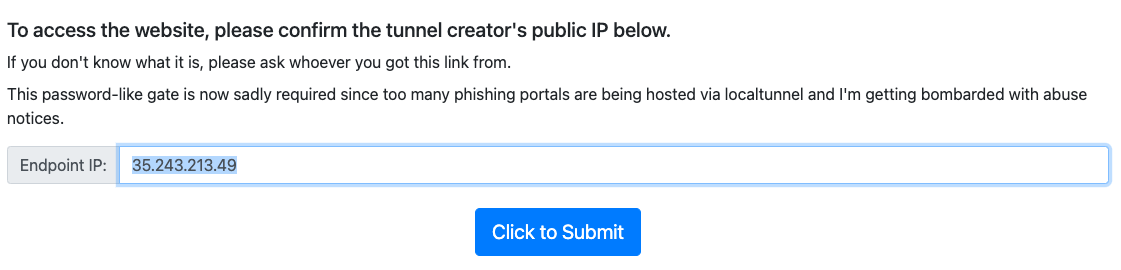

Move the py script file to a VM if long running Chatbot is needed.
Add a HTTP Load Balancer in front of the VM and Add a FQDN if you want to serve the chatbot in HTTPS

#### **Few Shot Template (Optional) / Try to these prompts**

In [ ]:
example = """Question: 今年消費券是怎樣發放？
Answer: 根據2023-2024財政年度 政府財政預算案，今年香港政府會向每名合資格的十八歲或以上永久性居民及新來港人士分兩期發放總額 $5000 電子消費券。首期 $3000 元消費券會在四月發放，第二期 $2000 元消費券會在今年年中發放。

Question: 今年消費券有多少錢？
Answer: 根據2023-2024財政年度 政府財政預算案，今年消費券發放總額是 $5000

Question: 今年政府會不會向香港市民派錢？
Answer: 會。根據2023-2024財政年度 政府財政預算案，今年香港政府會向每名合資格的十八歲或以上永久性居民及新來港人士分兩期發放總額 $5000 電子消費券。首期 $3000 元消費券會在四月發放，第二期 $2000 元消費券會在今年年中發放。

Question: 今年薪俸稅個人免稅額有多少？
Answer: 根據2023-2024財政年度 政府財政預算案，今年薪俸稅個人免稅額是132,000。

Question: 如果一個家庭有一對夫婦兩個其他年度出生小朋友，總共有多少免稅額？
Answer: 根據2023-2024財政年度 政府財政預算案，可以這樣計算：

1. 夫妻二人的個人免稅額都是132,000，所以總共有264,000。
2. 第一個小孩的免稅額是130,000，第二個小孩的免稅額是130,000，所以總共有260,000。
3. 所以，這個家庭的總免稅額是264,000+260,000=524,000。

Question: 今年出生小孩的免稅額有多少？
Answer: 根據2023-2024財政年度 政府財政預算案，今年出生小孩的免稅額是260,000。

Question: """

#### **Clean Up**

In [ ]:
# mengine.delete_index_endpoint()

In [ ]:
# mengine.delete_index()